# Imports

In [1]:
import pandas as pd
import sklearn.metrics as metrics
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
import talos
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
from time import sleep
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, TimeDistributed, LSTM, Lambda
from tensorflow.keras import regularizers
import tensorflow as tf

Using TensorFlow backend.


# Load data
load hospitalisations and trends for Belgium and France

In [2]:
# topics considered
list_topics = {
    'Fièvre': '/m/0cjf0',
    #'Mal de gorge': '/m/0b76bty',
    #'Dyspnée': '/m/01cdt5',
    #'Agueusie': '/m/05sfr2',
    #'Anosmie': '/m/0m7pl',
    #'Coronavirus': '/m/01cpyy',
    #'Virus': '/m/0g9pc',
    #'Température corporelle humaine': '/g/1213j0cz',
    #'Épidémie': '/m/0hn9s',
    'Symptôme': '/m/01b_06',
    #'Thermomètre': '/m/07mf1',
    #'Grippe espagnole': '/m/01c751',
    #'Paracétamol': '/m/0lbt3',
    #'Respiration': '/m/02gy9_',
    #'Toux': '/m/01b_21'
}

geocodes = {
    'BE': "Belgique",
    #'FR-A': "Alsace-Champagne-Ardenne-Lorraine",
    #'FR-B': "Aquitaine-Limousin-Poitou-Charentes",
    #'FR-C': "Auvergne-Rhône-Alpes",
    #'FR-J': 'Ile-de-France'
}

In [3]:
date_begin = "2020-02-01"

def diff_percentage(list_values):
    new_list_values = [0]
    for i in range(1, len(list_values)):
        diff = list_values[i] - list_values[i-1]
        if diff == 0 or list_values[i] == 0:
            new_list_values.append(0)
        else:
            if list_values[i-1] == 0 and list_values[i] != 0:
                new_list_values.append(1.0)
            else:
                diff = diff / list_values[i-1]
                new_list_values.append(diff)
    # Normalization between 0 and 1
    new_list_values = [(x-min(new_list_values))/(max(new_list_values)-min(new_list_values)) for x in new_list_values]
    return new_list_values

def log_values(df, columns: list = None, replace: bool = False, base: int = 10):
    """
    :param columns: list of name of the columns that needs to be modified. None= all columns
    :param replace: True if the columns needs to be replaced. Otherwhise, append the new columns
    :param base: base for the logarithm. Supported: [10]. If not in the list, use logarithm in base e
    :return dataframe with log values for the corresponding columns
    """
    if columns==None:
        columns = df.columns
    
    if replace:
        new_columns = columns
    else:
        new_columns = [f"{name}_log" for name in columns]
        
    if base==10:
        df[new_columns] = np.log10(df[columns])
    else:
        df[new_columns] = np.log(df[columns]) / np.log(base)
    df = df.replace([np.inf, -np.inf], np.nan).dropna()
    print(df)
    return df
        

def create_dataframe_hospi(hospi_france, hospi_belgium, department_france, geo, percentage=True, total=True):
    """
    Creates the dataframe containing the number of daily new hospitalizations
    with respect to the date and the localisation (FR and BE)
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    departements = pd.read_csv(department_france)
    hospitalisations = pd.read_csv(hospi_france, sep=";", parse_dates=['jour'], date_parser=date_parser)
    hospitalisations = hospitalisations[hospitalisations['sexe'] == 0]  # sex=0: men and women
    data_fr = hospitalisations.join(departements.set_index('departmentCode'), on="dep").groupby(["regionTrends", "jour"],
                                                                                                as_index=False).agg(
        {"hosp": "sum"})
    data_fr = data_fr.rename(columns={"jour": "DATE", "hosp": "HOSP", "regionTrends": "LOC"})
    
    # Belgian data
    data_be = pd.read_csv(hospi_belgium).groupby(["DATE"]).agg({"TOTAL_IN": "sum"}).reset_index().rename(
        columns={"TOTAL_IN": "HOSP"})
    data_be["LOC"] = "BE"
    
    if total:
        data_fr["TOT_HOSP"] = data_fr['HOSP']
        data_be["TOT_HOSP"] = data_be['HOSP']

    # Full data
    full_data = data_fr.append(data_be).set_index(["LOC", "DATE"])
    
    # find smallest date for each loc and highest common date
    smallest = {}
    highest = {}
    for loc, date_current in full_data.index:
        if loc not in smallest or smallest[loc] > date_current:
            smallest[loc] = date_current
        if loc not in highest or highest[loc] < date_current:
            highest[loc] = date_current
        
    highest_date = min(highest.values())
    base_date = datetime.strptime(date_begin, "%Y-%m-%d").date()
    
    # get the same maximum date on all region
    #full_data.index = full_data.index.swaplevel(0, 1)
    #full_data = full_data.sort_index()
    #full_data = full_data.loc[pd.IndexSlice[:highest_date,:,:]]
    #full_data.index = full_data.index.swaplevel(0, 1)

    # Add "fake" data (zeroes before the beginning of the crisis) for each loc
    toadd = []
    for loc, sm in smallest.items():
        end = sm.date()
        cur = base_date

        while cur != end:
            toadd.append([cur, loc, 0])
            cur += timedelta(days=1)
            
    full_data = pd.DataFrame(toadd, columns=["DATE", "LOC", "HOSP"]).append(full_data.reset_index()).set_index(
        ["LOC", "DATE"])
    data_dic = {}
    max_date = base_date
    for k, v in geo.items():
        data_dic[k] = full_data.iloc[full_data.index.get_level_values('LOC') == k]
        if percentage:
            #new_list_hospi = diff_percentage(data_dic[k]['HOSP'])
            #data_dic[k]['HOSP'] = new_list_hospi
            data_dic[k]['HOSP'] = data_dic[k]['HOSP'].pct_change()
        if total:
            data_dic[k]['TOT_HOSP'] = data_dic[k]['TOT_HOSP'].fillna(0.0)
    
    return data_dic


def create_df_trends(url_trends, geo, percentage=True, total=True):
    """
    return dic of {geo: df} for the trends
    """
    date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
    renaming = {v: k for k, v in list_topics.items()}  # change topic_mid to topic_title in the dataframe
    result = {}
    for k, v in geo.items():
        all_trends = []
        for term in list_topics.keys():
            path = f"{url_trends}{k}-{term}.csv"
            encoded_path = requests.get(path).content
            df_trends = pd.read_csv(io.StringIO(encoded_path.decode("utf-8")),
                                    parse_dates=['date'], date_parser=date_parser
                                   ).rename(columns={"date": "DATE"})
            df_trends['LOC'] = k
            df_trends.rename(columns=renaming, inplace=True)
            df_trends.set_index(['LOC', 'DATE'], inplace=True)
            if total:
                df_trends[f"total_{term}"] = df_trends[term]
            if percentage:
                new_list_trends = diff_percentage(df_trends[term])
                df_trends[term] = new_list_trends
            all_trends.append(df_trends)
        result[k] = pd.concat(all_trends, axis=1)
    return result

In [4]:
url_trends = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/trends/model/"
url_hospi_belgium = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/be-covid-hospi.csv"
url_department_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/src/france_departements.csv"
url_hospi_france = "https://raw.githubusercontent.com/gerardmargaux/CovidThesis/master/data/hospi/fr-covid-hospi-total.csv"
# Percentage is True if we want to take the difference of variation between today and yesterday in percentage
# Total is True if we want to add the absolute total value to the input of the model
df_trends = create_df_trends(url_trends, geocodes, percentage=False, total=False)
df_hospi = create_dataframe_hospi(url_hospi_france, url_hospi_belgium, url_department_france, geocodes, percentage=False, total=False)

for k in geocodes.keys():
    # Rolling average of 7 days 
    df_hospi[k] = df_hospi[k].rolling(7, center=True).mean().dropna()
    df_trends[k] = df_trends[k].rolling(7, center=True).mean().dropna()
    """
    print(f"--------------------{k}-----------------------")
    plt.figure()
    plt.plot(df_hospi[k]['HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Diff hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_hospi[k]['TOT_HOSP'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Total hospi')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(df_trends[k]['Fièvre'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Fièvre')
    plt.plot(df_trends[k]['Mal de gorge'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Mal de gorge')
    plt.plot(df_trends[k]['Agueusie'].reset_index().drop(columns=["LOC"]).set_index('DATE'), label='Agueusie')
    plt.legend()
    plt.show()
    """


#df_hospi

In [5]:
df_hospi = {k: df_hospi[k] for k in geocodes}
df_hospi['BE'] = log_values(df_hospi['BE'], columns=['HOSP'])
"""
plt.plot(df_hospi['BE'][['TOT_HOSP_log']].reset_index().drop(columns=["LOC"]).set_index('DATE'))
plt.figure()
plt.plot(df_hospi['BE'][['TOT_HOSP']].reset_index().drop(columns=["LOC"]).set_index('DATE'))
"""

                       HOSP  HOSP_log
LOC DATE                             
BE  2020-03-12    38.000000  1.579784
    2020-03-13    90.857143  1.958359
    2020-03-14   161.857143  2.209132
    2020-03-15   254.714286  2.406053
    2020-03-16   375.285714  2.574362
...                     ...       ...
    2020-12-21  2537.428571  3.404394
    2020-12-22  2490.000000  3.396199
    2020-12-23  2456.571429  3.390329
    2020-12-24  2431.285714  3.385836
    2020-12-25  2407.000000  3.381476

[289 rows x 2 columns]


'\nplt.plot(df_hospi[\'BE\'][[\'TOT_HOSP_log\']].reset_index().drop(columns=["LOC"]).set_index(\'DATE\'))\nplt.figure()\nplt.plot(df_hospi[\'BE\'][[\'TOT_HOSP\']].reset_index().drop(columns=["LOC"]).set_index(\'DATE\'))\n'

# Preprocess data

## Normalization [0,1]

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
for k in geocodes.keys():
    df_trends[k] = pd.DataFrame(scaler.fit_transform(df_trends[k].values), columns=df_trends[k].columns, index=df_trends[k].index)
    df_hospi[k] = pd.DataFrame(scaler.fit_transform(df_hospi[k].values), columns=df_hospi[k].columns, index=df_hospi[k].index)
df_hospi['BE']

HOSP  HOSP_log
LOC DATE                          
BE  2020-03-12  0.000000  0.000000
    2020-03-13  0.007366  0.166160
    2020-03-14  0.017260  0.276226
    2020-03-15  0.030200  0.362656
    2020-03-16  0.047003  0.436528
...                  ...       ...
    2020-12-21  0.348311  0.800835
    2020-12-22  0.341701  0.797239
    2020-12-23  0.337043  0.794662
    2020-12-24  0.333519  0.792690
    2020-12-25  0.330135  0.790777

[289 rows x 2 columns]

## Days used for the forecast
Each forecast is done for `n_forecast` days and uses `n_samples` days before to construct the prediction

In [7]:
n_forecast = 1  # Number of days we want to predict
n_samples = 14  # Number of days used to make the prediction
shift_hospi = 1  # delay between a date and its newest hosp value for this date 
# (ex: 26/10's newest value is for 25/10)
shift_trends = 1  # delay between a date and its newest trends value for this date
target = 'HOSP_log'

## Add lag

In [8]:
def timeseries_shift(data, lag, dropna=True):
    """
    Changes all columns with their shifted data
    """
    return data.shift(lag).dropna()

for k in geocodes.keys():
    df_hospi[k] = timeseries_shift(df_hospi[k], shift_hospi)
    df_trends[k] = timeseries_shift(df_trends[k], shift_trends)

In [9]:
def timeseries_add_lag(data, lag, dropna=True):
    """
    Adds lagged values to dataframe
    """
    df = pd.DataFrame(data)
    init_columns = df.columns
    columns = [df.shift(i) for i in range(lag-1, 0, -1)]
    renaming = {}  # rename the columns
    delay = lag-1
    for i in range(lag-1):
        for k in init_columns:
            renaming[k] = f'{k}(t-{delay})'
        columns[i].rename(columns=renaming ,inplace=True)
        delay -= 1
    columns.append(df)
    df = pd.concat(columns, axis=1)
    return df.dropna() if dropna else df

merged_df = {k: pd.merge(df_hospi[k], df_trends[k], left_index=True, right_index=True).dropna() for k,v in geocodes.items()}

# use the same date interval in all dataframes
min_date = datetime.strptime("1990-12-01", "%Y-%m-%d").date()
max_date = datetime.strptime("2050-12-01", "%Y-%m-%d").date()
for k in merged_df:
    index_date = merged_df[k].index.get_level_values(1)
    min_date = max(min_date, index_date.min())
    max_date = min(max_date, index_date.max())
for k in merged_df:
    merged_df[k] = merged_df[k].loc[pd.IndexSlice[:,min_date:max_date,:]]    

n_features = len(merged_df['BE'].columns)
lagged_df = {}
for k in geocodes.keys():
    lagged_df[k] = timeseries_add_lag(merged_df[k], n_samples)

In [10]:
lagged_df['BE']

HOSP(t-13)  HOSP_log(t-13)  Fièvre(t-13)  Symptôme(t-13)  \
LOC DATE                                                                   
BE  2020-03-26    0.000000        0.000000      0.738341        0.843665   
    2020-03-27    0.007366        0.166160      0.848918        0.939387   
    2020-03-28    0.017260        0.276226      0.936887        0.994253   
    2020-03-29    0.030200        0.362656      1.000000        1.000000   
    2020-03-30    0.047003        0.436528      0.991432        0.947798   
...                    ...             ...           ...             ...   
    2020-12-18    0.466664        0.855868      0.037090        0.030176   
    2020-12-19    0.455297        0.851220      0.035449        0.035657   
    2020-12-20    0.444228        0.846584      0.025900        0.037323   
    2020-12-21    0.435150        0.842695      0.019461        0.043199   
    2020-12-22    0.426151        0.838760      0.007366        0.046532   

                HOSP(t-12)  HOSP_log(t-12)  Fièvre(t-12)  Symptôme(t-12)  \
LOC DATE                                                                   
BE  2020-03-26    0.007366        0.166160      0.848918        0.939387   
    2020-03-27    0.017260        0.276226      0.936887        0.994253   
    2020-03-28    0.030200        0.362656      1.000000        1.000000   
    2020-03-29    0.047003        0.436528      0.991432        0.947798   
    2020-03-30    0.068922        0.503249      0.959815        0.861793   
...                    ...             ...           ...             ...   
    2020-12-18    0.455297        0.851220      0.035449        0.035657   
    2020-12-19    0.444228        0.846584      0.025900        0.037323   
    2020-12-20    0.435150        0.842695      0.019461        0.043199   
    2020-12-21    0.426151        0.838760      0.007366        0.046532   
    2020-12-22    0.418327        0.835272      0.004277        0.051882   

                HOSP(t-11)  HOSP_log(t-11)  ...  Fièvre(t-2)  Symptôme(t-2)  \
LOC DATE                                    ...                               
BE  2020-03-26    0.017260        0.276226  ...     0.529881       0.451598   
    2020-03-27    0.030200        0.362656  ...     0.492730       0.420945   
    2020-03-28    0.047003        0.436528  ...     0.464436       0.397217   
    2020-03-29    0.068922        0.503249  ...     0.437274       0.367085   
    2020-03-30    0.096474        0.563430  ...     0.407473       0.338567   
...                    ...             ...  ...          ...            ...   
    2020-12-18    0.444228        0.846584  ...     0.051552       0.054600   
    2020-12-19    0.435150        0.842695  ...     0.065535       0.058064   
    2020-12-20    0.426151        0.838760  ...     0.063656       0.059468   
    2020-12-21    0.418327        0.835272  ...     0.071482       0.058328   
    2020-12-22    0.411379        0.832119  ...     0.041931       0.060783   

                HOSP(t-1)  HOSP_log(t-1)  Fièvre(t-1)  Symptôme(t-1)  \
LOC DATE                                                               
BE  2020-03-26   0.323207       0.786798     0.492730       0.420945   
    2020-03-27   0.377058       0.815734     0.464436       0.397217   
    2020-03-28   0.433477       0.841970     0.437274       0.367085   
    2020-03-29   0.493480       0.866402     0.407473       0.338567   
    2020-03-30   0.550198       0.886931     0.393820       0.319238   
...                   ...            ...          ...            ...   
    2020-12-18   0.373952       0.814179     0.065535       0.058064   
    2020-12-19   0.367522       0.810920     0.063656       0.059468   
    2020-12-20   0.361988       0.808069     0.071482       0.058328   
    2020-12-21   0.357707       0.805834     0.041931       0.060783   
    2020-12-22   0.353009       0.803351     0.048067       0.061368   

                    HOSP  HOSP_log    Fièvre  Symptôme  
LOC DATE        

## Reshape
The data is reshaped in order to obtain the right format for LSTM:

`[nb_samples, timesteps, input_dim]`

In [11]:
# shape format for LSTM: [nb_samples, timesteps, input_dim]
dataset = {}
for k in geocodes.keys():
    dataset[k] = lagged_df[k].values.reshape(lagged_df[k].shape[0], n_samples, n_features)
dataset['BE'].shape

(272, 14, 4)

We want the targets to be always differents. For instance, if we use 2 days of forecast based on 3 days of data and the days are indexed as integers we want to have:
1. `x: [1,2,3]`, `y: [4,5]`
2. `x: [3,4,5]`, `y: [6,7]`
2. `x: [5,6,7]`, `y: [8,9]`

and so on. **But** this is only done for the fitting of the data. For the prediction itself, we will do it with one days of steps. In the end, if we use days 1 to 7 for the fit and want to predict afterwards, it will look like:

- **fit**: 
    1. `x: [1,2,3]`, `y: [4,5]`
    2. `x: [3,4,5]`, `y: [6,7]`
- **prediction**
    1. `x: [5,6,7]`, `y: [8,9]`
    2. `x: [6,7,8]`, `y: [9,10]`
    
    and so on
    
The prediction presents overlaps in order to obtain a real-time tool, that can be actualized every day

In [12]:
target = 'HOSP_log'
target_idx = lagged_df['BE'].columns.to_list().index(target)
target_idx = target_idx % ((n_samples-1) * n_features)
target_idx

1

In [13]:
# we take all possible dates for y. If not all dates can be taken, the first dates are dropped
first_set = (len(dataset) - 1) % n_forecast
all_x_set = {}
all_y_set = {}
for k in geocodes:
    all_y_set[k] = np.array([ [dataset[k][i+j+1,n_samples-1,target_idx] for j in range(n_forecast)] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_x_set[k] = np.array([ dataset[k][i] for i in range(first_set, len(dataset[k])-n_forecast)])
    all_y_set[k] = all_y_set[k].reshape(len(all_x_set[k]), n_forecast, 1)

In [14]:
dates = [d.to_pydatetime().date() for d in lagged_df['BE'].index.get_level_values(1)]
x_dates = [ dates[i] for i in range(first_set, len(dataset['BE'])-n_forecast)]
y_dates = [ [dates[i+j+1] for j in range(n_forecast)] for i in range(first_set, len(dataset['BE'])-n_forecast)]
print(f'y_dates=\n', y_dates)
print(f'x_dates=\n', x_dates)

y_dates=
 [[datetime.date(2020, 3, 27)], [datetime.date(2020, 3, 28)], [datetime.date(2020, 3, 29)], [datetime.date(2020, 3, 30)], [datetime.date(2020, 3, 31)], [datetime.date(2020, 4, 1)], [datetime.date(2020, 4, 2)], [datetime.date(2020, 4, 3)], [datetime.date(2020, 4, 4)], [datetime.date(2020, 4, 5)], [datetime.date(2020, 4, 6)], [datetime.date(2020, 4, 7)], [datetime.date(2020, 4, 8)], [datetime.date(2020, 4, 9)], [datetime.date(2020, 4, 10)], [datetime.date(2020, 4, 11)], [datetime.date(2020, 4, 12)], [datetime.date(2020, 4, 13)], [datetime.date(2020, 4, 14)], [datetime.date(2020, 4, 15)], [datetime.date(2020, 4, 16)], [datetime.date(2020, 4, 17)], [datetime.date(2020, 4, 18)], [datetime.date(2020, 4, 19)], [datetime.date(2020, 4, 20)], [datetime.date(2020, 4, 21)], [datetime.date(2020, 4, 22)], [datetime.date(2020, 4, 23)], [datetime.date(2020, 4, 24)], [datetime.date(2020, 4, 25)], [datetime.date(2020, 4, 26)], [datetime.date(2020, 4, 27)], [datetime.date(2020, 4, 28)], [datetim

## Split into train - test set

In [15]:
datapoints = {loc: (all_x_set[loc], all_y_set[loc]) for loc in geocodes}
print(datapoints['BE'][0].shape)
print(datapoints['BE'][1].shape)
# shape format for LSTM: [nb_samples, timesteps, input_dim]

(271, 14, 4)
(271, 1, 1)


In [16]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(64, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
model.compile(loss="mse", optimizer='adam')
print(model.output_shape)

(None, 1)


## Real-time prediction

In [18]:
fit_first_days = 250  # use 90 days for the first fit
fit_steps_days = 30  # every 30 days, do a new fit of the data
epochs = 10 # epochs used to train the model

In [19]:
def data_generator(idx):
    """
    yield data points (X,Y) in all possible loc, on the indices provided
    """
    while True:
        for loc in datapoints:
            yield (datapoints[loc][0][idx],
                  datapoints[loc][1][idx])
            
def data_value_region(idx, loc):
    return (datapoints[loc][0][idx], datapoints[loc][1][idx])

In [75]:
all_prediction = {k: [] for k in geocodes}
all_targets = {k: [] for k in geocodes}
fit_used = []
fit_dates_used = []
prediction_dates_used = []
for day_fit in range(fit_first_days, len(all_x_set['BE']), fit_steps_days):
    fit_idx = list(range(0,day_fit,n_forecast))
    fit_used.append(fit_idx)
    
    history = model.fit(data_generator(fit_idx), steps_per_epoch=len(fit_idx), 
                        epochs=epochs, verbose=1, shuffle=True)
    
    max_predict = min(day_fit + fit_steps_days, len(all_x_set['BE']))
    predict_idx = list(range(day_fit, max_predict))
    
    fit_dates_used.append(np.array(y_dates[:max(fit_idx)+1]))
    predict_dates = np.array([y_dates[i] for i in predict_idx])
    prediction_dates_used.append(predict_dates)
    
    for loc in geocodes:
        X,Y = data_value_region(predict_idx, loc)
        prediction = model.predict(X)
        all_prediction[loc].append(prediction)
        all_targets[loc].append(Y)

Epoch 1/300
250/250 [==============================] - 2s 6ms/step - loss: 0.0038
Epoch 2/300
250/250 [==============================] - 3s 11ms/step - loss: 5.5898e-04
Epoch 3/300
250/250 [==============================] - 2s 8ms/step - loss: 4.2908e-04
Epoch 4/300
250/250 [==============================] - 2s 6ms/step - loss: 3.6702e-04
Epoch 5/300
250/250 [==============================] - 2s 6ms/step - loss: 3.3289e-04
Epoch 6/300
250/250 [==============================] - 2s 6ms/step - loss: 3.0533e-04
Epoch 7/300
250/250 [==============================] - 2s 6ms/step - loss: 2.8394e-04
Epoch 8/300
250/250 [==============================] - 1s 6ms/step - loss: 2.6886e-04
Epoch 9/300
250/250 [==============================] - 2s 6ms/step - loss: 2.5869e-04
Epoch 10/300
250/250 [==============================] - 2s 6ms/step - loss: 2.4922e-04
Epoch 11/300
250/250 [==============================] - 2s 6ms/step - loss: 2.4223e-04
Epoch 12/300
250/250 [==============================] -

250/250 [==============================] - 2s 6ms/step - loss: 5.9973e-06
Epoch 189/300
250/250 [==============================] - 2s 7ms/step - loss: 4.7962e-06
Epoch 190/300
250/250 [==============================] - 3s 11ms/step - loss: 6.5639e-06
Epoch 191/300
250/250 [==============================] - 1s 5ms/step - loss: 4.8708e-06
Epoch 192/300
250/250 [==============================] - 1s 5ms/step - loss: 6.0224e-06
Epoch 193/300
250/250 [==============================] - 1s 5ms/step - loss: 5.7286e-06
Epoch 194/300
250/250 [==============================] - 2s 6ms/step - loss: 4.8763e-06
Epoch 195/300
250/250 [==============================] - 2s 7ms/step - loss: 6.0168e-06
Epoch 196/300
250/250 [==============================] - 2s 7ms/step - loss: 5.4705e-06
Epoch 197/300
250/250 [==============================] - 1s 5ms/step - loss: 5.1635e-06
Epoch 198/300
250/250 [==============================] - 1s 6ms/step - loss: 4.8233e-06
Epoch 199/300
250/250 [======================

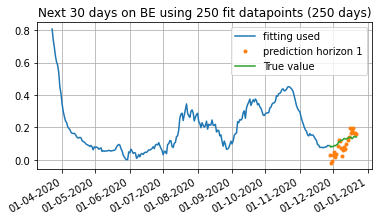

In [76]:
for loc in all_prediction:
    for i, pred in enumerate(all_prediction[loc]):
        prediction = pred
        fit = datapoints[loc][1][:max(fit_used[i])+1][:,0].reshape(-1)
        target = np.array(all_targets[loc][i])
        
        fit_dates = fit_dates_used[i][:,0]
        prediction_dates = prediction_dates_used[i][:,0]
        
        fig = plt.figure(figsize=(6,3))
        plt.plot(fit_dates, fit, label="fitting used")
        plt.plot(prediction_dates, prediction[:,0], '.', label="prediction horizon 1")
        plt.plot(prediction_dates, target[:,0], label="True value")
        
        ax = fig.axes[0]
        # set monthly locator
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        # set formatter
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
        # set font and rotation for date tick labels
        plt.gcf().autofmt_xdate()
        
        plt.legend()
        plt.grid()
        days_used = fit_first_days + i*fit_steps_days
        plt.title(f"Next {fit_steps_days} days on {loc} using {len(fit_used[i])} fit datapoints ({days_used} days)")
        #plt.savefig(f"fit_{len(fit_used[i])}.png", dpi=300)

In [42]:
x_dates

[datetime.date(2020, 3, 26),
 datetime.date(2020, 3, 27),
 datetime.date(2020, 3, 28),
 datetime.date(2020, 3, 29),
 datetime.date(2020, 3, 30),
 datetime.date(2020, 3, 31),
 datetime.date(2020, 4, 1),
 datetime.date(2020, 4, 2),
 datetime.date(2020, 4, 3),
 datetime.date(2020, 4, 4),
 datetime.date(2020, 4, 5),
 datetime.date(2020, 4, 6),
 datetime.date(2020, 4, 7),
 datetime.date(2020, 4, 8),
 datetime.date(2020, 4, 9),
 datetime.date(2020, 4, 10),
 datetime.date(2020, 4, 11),
 datetime.date(2020, 4, 12),
 datetime.date(2020, 4, 13),
 datetime.date(2020, 4, 14),
 datetime.date(2020, 4, 15),
 datetime.date(2020, 4, 16),
 datetime.date(2020, 4, 17),
 datetime.date(2020, 4, 18),
 datetime.date(2020, 4, 19),
 datetime.date(2020, 4, 20),
 datetime.date(2020, 4, 21),
 datetime.date(2020, 4, 22),
 datetime.date(2020, 4, 23),
 datetime.date(2020, 4, 24),
 datetime.date(2020, 4, 25),
 datetime.date(2020, 4, 26),
 datetime.date(2020, 4, 27),
 datetime.date(2020, 4, 28),
 datetime.date(2020, 4,

# Comparison between several models

In [40]:
end_train = "2020-09-15"  # dates with respect to x, included
end_valid = "2020-11-20"
end_test = "2020-12-25"
epochs = 100

date_f = "%Y-%m-%d"
max_dates = [datetime.strptime(end_train, date_f).date(),
            datetime.strptime(end_valid, date_f).date(),
            datetime.strptime(end_test, date_f).date()]
max_dates[-1] = min(max(x_dates), max_dates[-1])
max_train_idx, max_valid_idx, max_test_idx = np.where(np.isin(x_dates, max_dates))[0]

train_idx = list(reversed(range(max_train_idx, -1, -n_forecast)))
valid_idx = list(range(max_train_idx+1, max_valid_idx+1))
test_idx = list(range(max_valid_idx+1, max_test_idx+1))

def train_generator():
    return data_generator(train_idx)

def validation_generator():
    return data_generator(valid_idx)

def test_generator():
    return data_generator(valid_idx)

train_datapoints = {loc: data_value_region(train_idx, loc) for loc in geocodes}
valid_datapoints = {loc: data_value_region(valid_idx, loc) for loc in geocodes}
test_datapoints = {loc: data_value_region(test_idx, loc) for loc in geocodes}

## Toy model

In [41]:
model = Sequential()
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=True))
model.add(LSTM(32, input_shape=(n_samples, n_features), return_sequences=False))
model.add(Dense(n_forecast))
LSTMModel = model
print(model.output_shape)

(None, 1)


In [42]:
#history = model.fit(x_train, y_train, epochs=400, verbose=1, shuffle=False)
LSTMModel.compile(loss="mse", optimizer='adam')
history = LSTMModel.fit(train_generator(), steps_per_epoch=100, epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_idx))

Epoch 1/100
100/100 [==============================] - 2s 21ms/step - loss: 0.0217 - val_loss: 0.0035
Epoch 2/100
100/100 [==============================] - 2s 17ms/step - loss: 3.7162e-04 - val_loss: 0.0033
Epoch 3/100
100/100 [==============================] - 2s 15ms/step - loss: 3.4638e-04 - val_loss: 0.0030
Epoch 4/100
100/100 [==============================] - 2s 16ms/step - loss: 3.2789e-04 - val_loss: 0.0027
Epoch 5/100
100/100 [==============================] - 2s 17ms/step - loss: 3.1153e-04 - val_loss: 0.0024
Epoch 6/100
100/100 [==============================] - 2s 15ms/step - loss: 2.9536e-04 - val_loss: 0.0021
Epoch 7/100
100/100 [==============================] - 1s 15ms/step - loss: 2.7898e-04 - val_loss: 0.0018
Epoch 8/100
100/100 [==============================] - 1s 15ms/step - loss: 2.6224e-04 - val_loss: 0.0015
Epoch 9/100
100/100 [==============================] - 1s 15ms/step - loss: 2.4482e-04 - val_loss: 0.0012
Epoch 10/100
100/100 [============================

100/100 [==============================] - 2s 16ms/step - loss: 1.9797e-05 - val_loss: 2.9713e-04
Epoch 76/100
100/100 [==============================] - 2s 16ms/step - loss: 7.2217e-06 - val_loss: 2.8488e-04
Epoch 77/100
100/100 [==============================] - 2s 16ms/step - loss: 7.0104e-06 - val_loss: 2.7469e-04
Epoch 78/100
100/100 [==============================] - 2s 16ms/step - loss: 1.4643e-05 - val_loss: 1.6424e-04
Epoch 79/100
100/100 [==============================] - 2s 16ms/step - loss: 1.1313e-05 - val_loss: 2.6377e-04
Epoch 80/100
100/100 [==============================] - 2s 16ms/step - loss: 6.5379e-06 - val_loss: 2.5138e-04
Epoch 81/100
100/100 [==============================] - 2s 16ms/step - loss: 6.3374e-06 - val_loss: 2.4216e-04
Epoch 82/100
100/100 [==============================] - 2s 16ms/step - loss: 1.8178e-05 - val_loss: 2.5596e-04
Epoch 83/100
100/100 [==============================] - 2s 16ms/step - loss: 7.3602e-06 - val_loss: 2.2849e-04
Epoch 84/100
1

TEST BE
MSE =  0.00021892778756095458
MAE =  0.013694567836857394


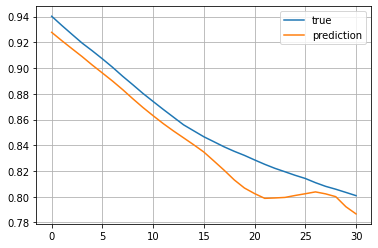

In [43]:
"""for loc in train_datapoints:
    print("TRAINING", loc)
    x, y = train_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()
    
for loc in valid_datapoints:
    print("VALIDATION", loc)
    x, y = valid_datapoints[loc]
    yp = model.predict(x)

    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()"""

for loc in test_datapoints:
    MSE = 0
    MAE = 0
    print("TEST", loc)
    x, y = test_datapoints[loc]
    yp = model.predict(x)
    MSE = mean_squared_error(y.reshape(-1), yp.reshape(-1))
    MAE = mean_absolute_error(y.reshape(-1), yp.reshape(-1))
    print("MSE = ", MSE)
    print("MAE = ", MAE)
    plt.plot(y.reshape(-1), label='true')
    plt.plot(yp.reshape(-1), label='prediction')
    plt.legend()
    plt.grid()
    plt.show()

In [44]:
# Let's use the validation set

## Base line models
### MultiStepLastBaseline
This model repeats the last value of hospitalisations `n_forecast` time

In [45]:
class MultiStepLastBaseline(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def call(self, inputs):
        a = inputs[:, -1:, target_idx:target_idx+1]  # hospitalisations of the last days
        return tf.tile(
            a,
            [1, n_forecast, 1]   # repeat hospitalisations n_forecast time
        )

BaselineModel = MultiStepLastBaseline()
BaselineModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

## Linear regression
linear regression of the last `n_sample` days used to predict the next `n_forecast` days

In [46]:
class LinearRegressionHospi(tf.keras.Model):
    """
    repeat the last hospitalisations given as input n_forecast time
    """
    def predict(self, inputs):
        y = inputs[:, :, 0]  # hospitalisations of the last days
        length = len(inputs)
        x = np.arange(n_samples).reshape(-1,1)  # dates of the hospitalisations
        result = np.zeros((length, n_forecast))
        for i in range(length):
            regr = LinearRegression().fit(x,y[i])  # linear regression of (days, hospi)
            result[i] = regr.predict(np.arange(n_samples, n_samples+n_forecast).reshape(-1,1))
        return result
        

## 1 fully connected layer (Dense model)

In [47]:
DenseModel = Sequential()
DenseModel.add(Lambda(lambda x: x[:,:,0]))  # select only the hospitalisations of the previous days
DenseModel.add(Dense(n_forecast))   # predict the next hospitalisations based on the previous ones
DenseModel.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

In [48]:
LinearModel_history = DenseModel.fit(train_generator(), steps_per_epoch=len(train_datapoints), epochs=epochs, verbose=1, shuffle=False, 
          validation_data=validation_generator(),
          validation_steps=len(valid_datapoints))

Epoch 1/100
1/1 [==============================] - 0s 103ms/step - loss: 0.2578 - mean_absolute_error: 0.4601 - val_loss: 0.5551 - val_mean_absolute_error: 0.7114
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 0.2440 - mean_absolute_error: 0.4476 - val_loss: 0.5344 - val_mean_absolute_error: 0.6970
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 0.2345 - mean_absolute_error: 0.4387 - val_loss: 0.5178 - val_mean_absolute_error: 0.6851
Epoch 4/100
1/1 [==============================] - 0s 25ms/step - loss: 0.2269 - mean_absolute_error: 0.4313 - val_loss: 0.5036 - val_mean_absolute_error: 0.6747
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.2203 - mean_absolute_error: 0.4248 - val_loss: 0.4910 - val_mean_absolute_error: 0.6652
Epoch 6/100
1/1 [==============================] - 0s 22ms/step - loss: 0.2145 - mean_absolute_error: 0.4189 - val_loss: 0.4795 - val_mean_absolute_error: 0.6564
Epoch 7/100
1/1 [==========

1/1 [==============================] - 0s 19ms/step - loss: 0.0998 - mean_absolute_error: 0.2605 - val_loss: 0.2504 - val_mean_absolute_error: 0.4612
Epoch 52/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0986 - mean_absolute_error: 0.2589 - val_loss: 0.2482 - val_mean_absolute_error: 0.4599
Epoch 53/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0974 - mean_absolute_error: 0.2575 - val_loss: 0.2460 - val_mean_absolute_error: 0.4587
Epoch 54/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0962 - mean_absolute_error: 0.2561 - val_loss: 0.2440 - val_mean_absolute_error: 0.4577
Epoch 55/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0951 - mean_absolute_error: 0.2548 - val_loss: 0.2420 - val_mean_absolute_error: 0.4567
Epoch 56/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0940 - mean_absolute_error: 0.2536 - val_loss: 0.2401 - val_mean_absolute_error: 0.4557
Epoch 57/100
1/1 [=================

# Comparisons of the models

In [49]:
#LSTMModel = scan_object.best_model(metric='val_mse', asc=True)  # retrieve the best model from the scan
all_models = {
    'RepeatLast': BaselineModel,
    'LSTM': LSTMModel,
    'Dense': DenseModel,
    'Linear regression': LinearRegressionHospi()
}

def error_set(models, points, plot=True):
    y_predicted = {k:[] for k in models.keys()}
    y_true = []
    length = 0
    for loc in points:
        print(loc)
        length += 1
        x, y = points[loc]
        y = y.reshape(-1)
        y_true.extend(y)
        for name, model in models.items():
            yp = model.predict(x)
            yp = yp.reshape(-1)
            if plot:
                plt.plot(y, label='true')
                plt.plot(yp, label='prediction')
                plt.legend()
                plt.grid()
                plt.title(name)
                plt.show()
            y_predicted[name].extend(yp)
    MSE = []
    MAE = []
    models_names = []
    for k in models.keys():
        models_names.append(k)
        MSE.append(mean_squared_error(y_true, y_predicted[k]))
        MAE.append(mean_absolute_error(y_true, y_predicted[k]))
    return pd.DataFrame(data={'Model': models_names, 'MSE': MSE, 'MAE': MAE}).set_index('Model').sort_values(by=['MSE'])

## Training

In [50]:
error_set(all_models, train_datapoints, plot=False)

BE


,MSE,MAE
Model,,
LSTM,0.000004,0.001504
RepeatLast,0.000059,0.006615
Dense,0.067951,0.221321
Linear regression,0.127767,0.341713


## Validation

BE


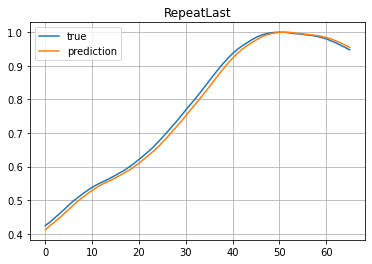

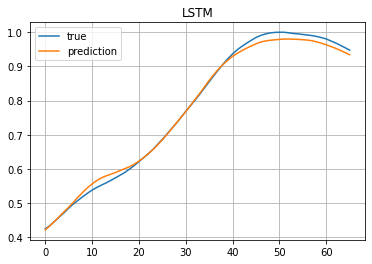

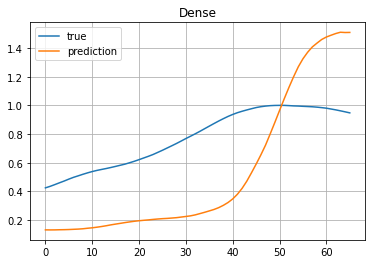

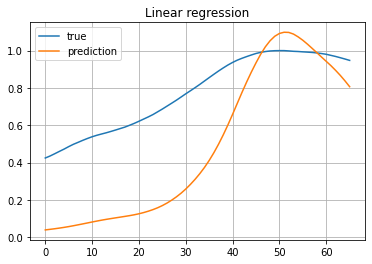

,MSE,MAE
Model,,
RepeatLast,0.000122,0.009713
LSTM,0.000158,0.009970
Linear regression,0.134699,0.313624
Dense,0.196897,0.423475


In [51]:
error_set(all_models, valid_datapoints)

## Test

BE


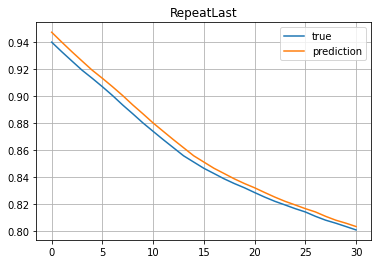

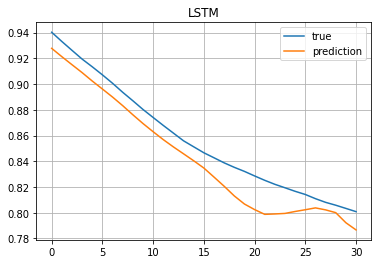

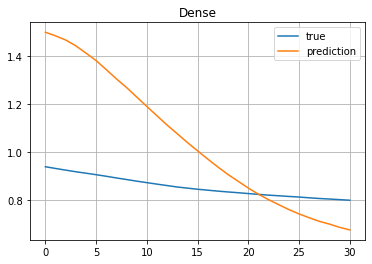

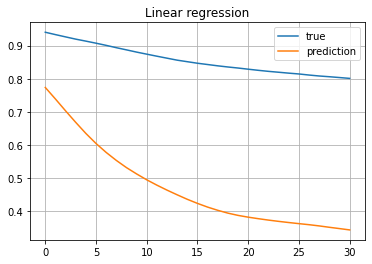

,MSE,MAE
Model,,
RepeatLast,0.000025,0.004734
LSTM,0.000219,0.013695
Dense,0.088825,0.233626
Linear regression,0.155490,0.385347


In [52]:
error_set(all_models, test_datapoints)